# **Trabalho Reconhecimento de Padrões**
- Iago Garcia Vargas
- Lara
- Damaris

> Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans

from scipy.stats import ttest_ind, f_oneway, chi2_contingency

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


Análise dos dados

In [3]:
path = "/Users/iagogvargas/Downloads/trabalho_rp/dados/dados_disciplinas.txt"

In [4]:
data = pd.read_csv(path)

In [5]:
data.head()

,MATR_ALUNO,ANO,PERIODO,SITUACAO,MEDIA_FINAL,NUM_FALTAS,DISCIPLINA
0,1,2013,1,Aprovado,77,12,2
1,2,2013,1,Reprovado por Frequencia,0,32,1
2,3,2013,1,Reprovado por Frequencia,0,50,4
3,4,2013,2,Aprovado,60,2,2
4,4,2013,2,Aprovado,68,2,5


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4642 entries, 0 to 4641
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MATR_ALUNO   4642 non-null   int64 
 1   ANO          4642 non-null   int64 
 2   PERIODO      4642 non-null   int64 
 3   SITUACAO     4642 non-null   object
 4   MEDIA_FINAL  4642 non-null   int64 
 5   NUM_FALTAS   4642 non-null   int64 
 6   DISCIPLINA   4642 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 254.0+ KB


In [7]:
# Padronizar texto da coluna SITUACAO
data["SITUACAO"] = data["SITUACAO"].str.strip()

In [8]:
data["SITUACAO"].unique()

array(['Aprovado', 'Reprovado por Frequencia', 'Equivalencia curricular',
       'Reprovado', 'Trancamento parcial', 'Dispensado'], dtype=object)

In [9]:
data.isna().sum()

MATR_ALUNO     0
ANO            0
PERIODO        0
SITUACAO       0
MEDIA_FINAL    0
NUM_FALTAS     0
DISCIPLINA     0
dtype: int64

In [10]:
# Garantir tipos numéricos
data["ANO"] = pd.to_numeric(data["ANO"], errors="coerce")
data["PERIODO"] = pd.to_numeric(data["PERIODO"], errors="coerce")
data["MEDIA_FINAL"] = pd.to_numeric(data["MEDIA_FINAL"], errors="coerce")
data["NUM_FALTAS"] = pd.to_numeric(data["NUM_FALTAS"], errors="coerce")
data["DISCIPLINA"] = pd.to_numeric(data["DISCIPLINA"], errors="coerce")

In [11]:
df = data.reset_index(drop=True)

In [13]:
# Limpeza e enriquecimento das variáveis essenciais
max_faltas = df["NUM_FALTAS"].mask(df["NUM_FALTAS"] < 0).max()
if pd.isna(max_faltas):
    max_faltas = 0

status_map = {
    "Aprovado": "Aprovado",
    "Reprovado": "Reprovado por nota",
    "Reprovado por Frequencia": "Reprovado por frequência",
}

df["MEDIA_FINAL_VALIDO"] = df["MEDIA_FINAL"].mask(df["MEDIA_FINAL"] < 0)
df["NUM_FALTAS_VALIDO"] = df["NUM_FALTAS"].mask(df["NUM_FALTAS"] < 0)
df["RESULTADO_AGRUPADO"] = df["SITUACAO"].replace(status_map).fillna("Outros")
df["APROVADO_BINARIO"] = (df["SITUACAO"] == "Aprovado").astype(int)
df["ANO_PERIODO"] = df["ANO"].astype(str) + "." + df["PERIODO"].astype(str)

bins_faltas = [-0.1, 5, 10, 20, 40, max_faltas + 1]
labels_faltas = ["0-4", "5-9", "10-19", "20-39", f"40-{int(max_faltas)}"]

df["FAIXA_FALTAS"] = pd.cut(
    df["NUM_FALTAS_VALIDO"].fillna(-0.1),
    bins=bins_faltas,
    labels=labels_faltas,
    right=False
)

df.head()


,MATR_ALUNO,ANO,PERIODO,SITUACAO,MEDIA_FINAL,NUM_FALTAS,DISCIPLINA,MEDIA_FINAL_VALIDO,NUM_FALTAS_VALIDO,RESULTADO_AGRUPADO,APROVADO_BINARIO,ANO_PERIODO,FAIXA_FALTAS
0,1,2013,1,Aprovado,77,12,2,77.0,12.0,Aprovado,1,2013.1,10-19
1,2,2013,1,Reprovado por Frequencia,0,32,1,0.0,32.0,Reprovado por frequência,0,2013.1,20-39
2,3,2013,1,Reprovado por Frequencia,0,50,4,0.0,50.0,Reprovado por frequência,0,2013.1,40-78
3,4,2013,2,Aprovado,60,2,2,60.0,2.0,Aprovado,1,2013.2,0-4
4,4,2013,2,Aprovado,68,2,5,68.0,2.0,Aprovado,1,2013.2,0-4


In [14]:
qualidade = pd.DataFrame({
    "Valores ausentes": df[["MEDIA_FINAL_VALIDO", "NUM_FALTAS_VALIDO"]].isna().sum(),
    "Percentual ausente (%)": (df[["MEDIA_FINAL_VALIDO", "NUM_FALTAS_VALIDO"]].isna().mean() * 100).round(2),
    "Média": df[["MEDIA_FINAL_VALIDO", "NUM_FALTAS_VALIDO"]].mean(),
    "Desvio-padrão": df[["MEDIA_FINAL_VALIDO", "NUM_FALTAS_VALIDO"]].std(),
})

qualidade

,Valores ausentes,Percentual ausente (%),Média,Desvio-padrão
MEDIA_FINAL_VALIDO,525,11.31,47.031091,32.210654
NUM_FALTAS_VALIDO,527,11.35,12.874605,15.756976


Estatística descritiva geral

In [15]:
print("Descrição geral das variáveis numéricas:")
print(df[["MEDIA_FINAL", "NUM_FALTAS", "ANO", "PERIODO"]].describe())

Descrição geral das variáveis numéricas:
       MEDIA_FINAL   NUM_FALTAS          ANO      PERIODO
count  4642.000000  4642.000000  4642.000000  4642.000000
mean     41.598880    11.299440  2014.994399     1.490521
std      33.935453    15.474717     1.435825     0.499964
min      -1.000000    -1.000000  2013.000000     1.000000
25%       3.000000     0.000000  2014.000000     1.000000
50%      43.000000     6.000000  2015.000000     1.000000
75%      72.000000    16.000000  2016.000000     2.000000
max     100.000000    78.000000  2017.000000     2.000000


In [16]:
print("\nContagem por situação:")
print(df["SITUACAO"].value_counts())


Contagem por situação:
SITUACAO
Aprovado                    2077
Reprovado                   1117
Reprovado por Frequencia     921
Dispensado                   456
Equivalencia curricular       37
Trancamento parcial           34
Name: count, dtype: int64


In [17]:
print("\nContagem por disciplina:")
print(df["DISCIPLINA"].value_counts())


Contagem por disciplina:
DISCIPLINA
2    1209
5     982
4     914
3     778
1     759
Name: count, dtype: int64


In [18]:
print("\nContagem por ano e período:")
print(df.groupby(["ANO", "PERIODO"])["MATR_ALUNO"].count())


Contagem por ano e período:
ANO   PERIODO
2013  1          495
      2          462
2014  1          438
      2          549
2015  1          416
      2          346
2016  1          530
      2          467
2017  1          486
      2          453
Name: MATR_ALUNO, dtype: int64


Distribuições (univariadas)

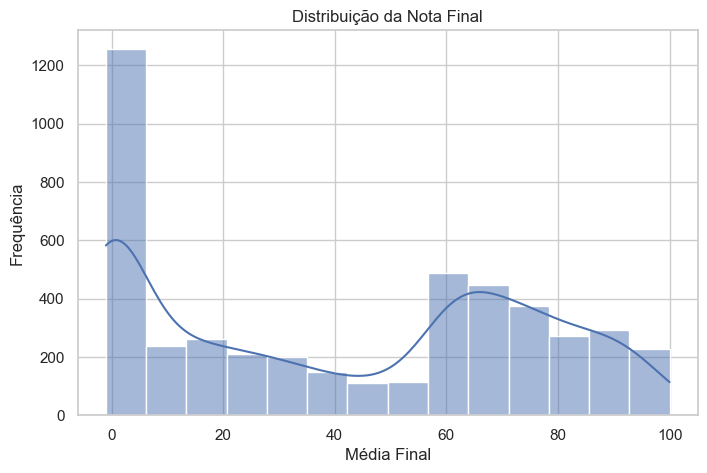

In [19]:
sns.histplot(df["MEDIA_FINAL"], kde=True)
plt.title("Distribuição da Nota Final")
plt.xlabel("Média Final")
plt.ylabel("Frequência")
plt.show()

#### Relação entre faltas e aprovação
A criação de faixas de faltas permite verificar como a adoção do controle de presença impacta diretamente a chance de aprovação.


/var/folders/c3/kxc5bhvn38d9s_lcfr31f3cw0000gn/T/ipykernel_12869/1008802684.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("FAIXA_FALTAS")["APROVADO_BINARIO"]
/var/folders/c3/kxc5bhvn38d9s_lcfr31f3cw0000gn/T/ipykernel_12869/1008802684.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=faltas_impacto, x="FAIXA_FALTAS", y="taxa_aprovacao", palette="viridis")


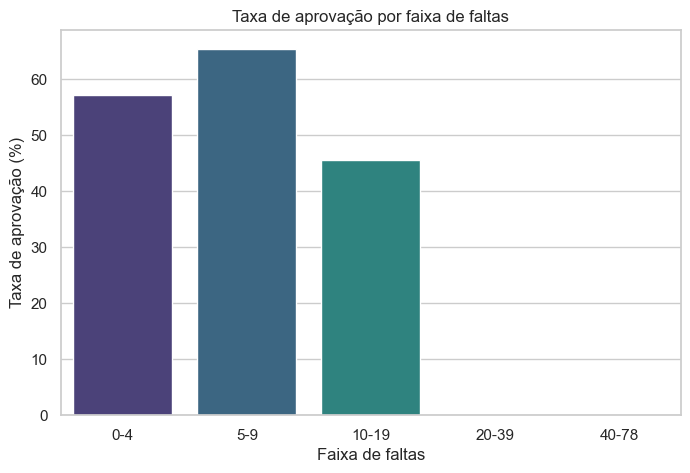

,FAIXA_FALTAS,taxa_aprovacao,n
0,0-4,57.2,2265
1,5-9,65.4,581
2,10-19,45.6,880
3,20-39,0.0,549
4,40-78,0.0,367


In [20]:
faltas_impacto = (
    df.dropna(subset=["FAIXA_FALTAS"])
      .groupby("FAIXA_FALTAS")["APROVADO_BINARIO"]
      .agg(taxa_aprovacao="mean", n="count")
      .reset_index()
)
faltas_impacto["taxa_aprovacao"] = (faltas_impacto["taxa_aprovacao"] * 100).round(1)

sns.barplot(data=faltas_impacto, x="FAIXA_FALTAS", y="taxa_aprovacao", palette="viridis")
plt.title("Taxa de aprovação por faixa de faltas")
plt.xlabel("Faixa de faltas")
plt.ylabel("Taxa de aprovação (%)")
plt.show()

faltas_impacto


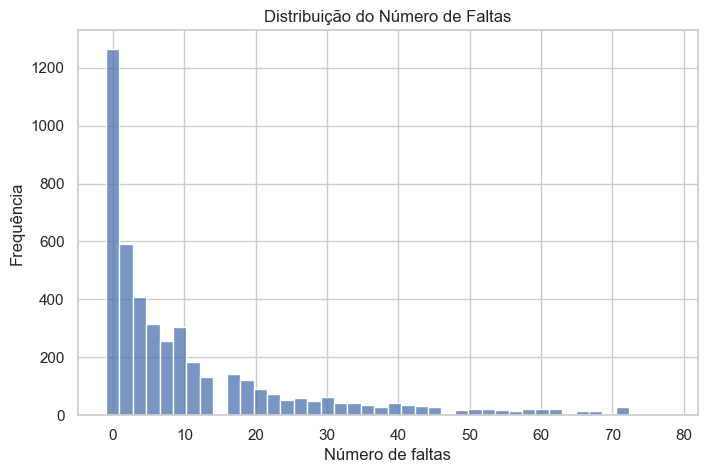

In [21]:
# Distribuição das faltas
sns.histplot(df["NUM_FALTAS"], kde=False)
plt.title("Distribuição do Número de Faltas")
plt.xlabel("Número de faltas")
plt.ylabel("Frequência")
plt.show()

#### Evolução temporal por disciplina
A matriz abaixo ajuda a identificar disciplinas e períodos críticos em termos de aprovação.


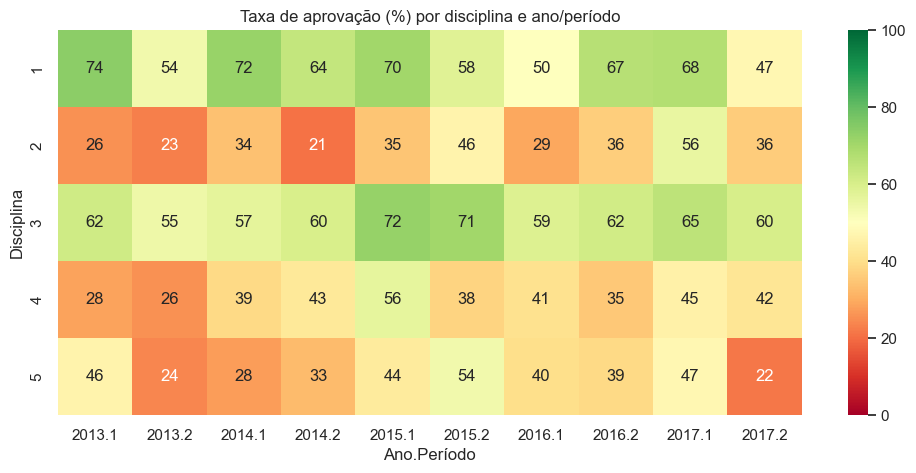

ANO_PERIODO,2013.1,2013.2,2014.1,2014.2,2015.1,2015.2,2016.1,2016.2,2017.1,2017.2
DISCIPLINA,,,,,,,,,,
1,74.1,53.6,72.1,64.2,70.4,58.0,50.0,66.7,67.5,47.4
2,25.7,23.0,33.9,20.8,34.5,46.5,29.1,36.4,55.6,36.2
3,61.7,54.7,56.7,59.8,72.3,70.6,59.0,61.5,65.4,60.2
4,28.3,25.7,39.0,42.6,56.3,37.7,40.8,35.4,45.4,42.1
5,46.4,23.9,27.6,32.6,43.6,53.6,40.0,38.7,47.4,21.6


In [22]:
col_order = sorted(df["ANO_PERIODO"].unique())

aprov_disc_tempo = (
    df.groupby(["DISCIPLINA", "ANO_PERIODO"])["APROVADO_BINARIO"].mean().unstack() * 100
).reindex(columns=col_order)

plt.figure(figsize=(12, 5))
sns.heatmap(aprov_disc_tempo, annot=True, fmt=".0f", cmap="RdYlGn", vmin=0, vmax=100)
plt.title("Taxa de aprovação (%) por disciplina e ano/período")
plt.xlabel("Ano.Período")
plt.ylabel("Disciplina")
plt.show()

aprov_disc_tempo.round(1)


In [23]:
# Estatísticas por situação
stats_situacao = df.groupby("SITUACAO")[["MEDIA_FINAL", "NUM_FALTAS"]].agg(
    ["mean", "median", "std", "count"]
)
print(stats_situacao)

                         MEDIA_FINAL                         NUM_FALTAS  \
                                mean median        std count       mean   
SITUACAO                                                                  
Aprovado                   75.297545   74.0  11.935926  2077   4.658642   
Dispensado                 -1.000000   -1.0   0.000000   456  -1.000000   
Equivalencia curricular     0.513514   -1.0   6.760266    37  -1.000000   
Reprovado                  25.885407   25.0  16.714644  1117   7.700090   
Reprovado por Frequencia    8.975027    1.0  13.558746   921  37.678610   
Trancamento parcial        -1.000000   -1.0   0.000000    34  -1.000000   

                                                  
                         median        std count  
SITUACAO                                          
Aprovado                    4.0   4.783813  2077  
Dispensado                 -1.0   0.000000   456  
Equivalencia curricular    -1.0   0.000000    37  
Reprovado         

In [24]:
# Estatísticas por disciplina (taxa de aprovação etc.)

# Taxa de aprovação por disciplina
disc_situacao = df.pivot_table(
    index="DISCIPLINA",
    columns="SITUACAO",
    values="MATR_ALUNO",
    aggfunc="count",
    fill_value=0
)

disc_situacao["TOTAL"] = disc_situacao.sum(axis=1)
if "Aprovado" in disc_situacao.columns:
    disc_situacao["PCT_APROVADO"] = disc_situacao["Aprovado"] / disc_situacao["TOTAL"]
else:
    disc_situacao["PCT_APROVADO"] = 0

print(disc_situacao.sort_values("PCT_APROVADO"))

SITUACAO    Aprovado  Dispensado  Equivalencia curricular  Reprovado  \
DISCIPLINA                                                             
2                404         112                        9        338   
5                354         101                       12        347   
4                362          70                        7        255   
3                484          77                        5        106   
1                473          96                        4         71   

SITUACAO    Reprovado por Frequencia  Trancamento parcial  TOTAL  PCT_APROVADO  
DISCIPLINA                                                                      
2                                329                   17   1209      0.334160  
5                                162                    6    982      0.360489  
4                                214                    6    914      0.396061  
3                                103                    3    778      0.622108  
1        

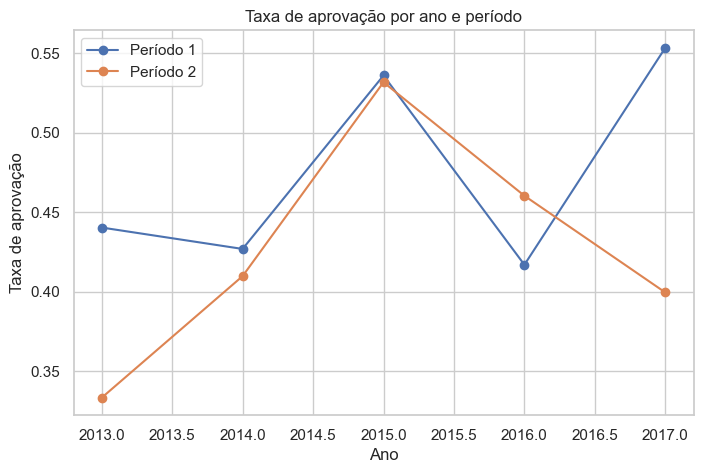

In [25]:
#  Taxa de aprovação por ano/período

aprov_por_ano = df.assign(
    APROVADO = df["SITUACAO"] == "Aprovado"
).groupby(["ANO", "PERIODO"])["APROVADO"].mean().reset_index()

# Gráfico simples
plt.figure()
for periodo in sorted(aprov_por_ano["PERIODO"].unique()):
    subset = aprov_por_ano[aprov_por_ano["PERIODO"] == periodo]
    plt.plot(subset["ANO"], subset["APROVADO"], marker="o", label=f"Período {periodo}")

plt.title("Taxa de aprovação por ano e período")
plt.xlabel("Ano")
plt.ylabel("Taxa de aprovação")
plt.legend()
plt.show()

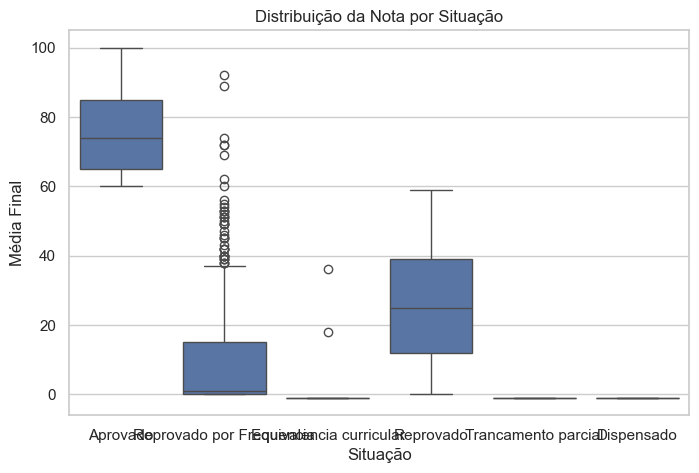

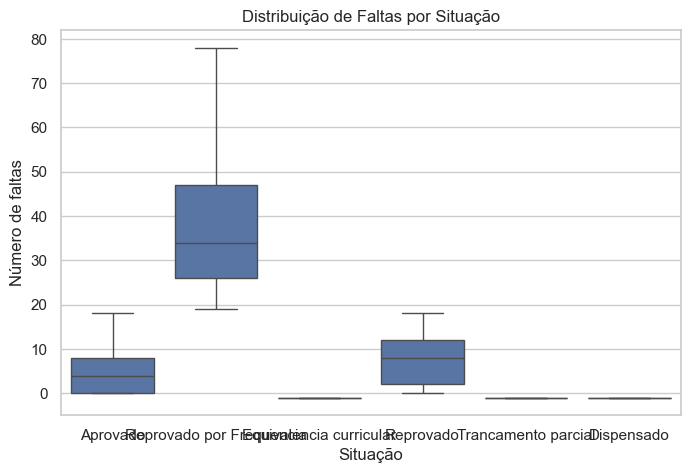

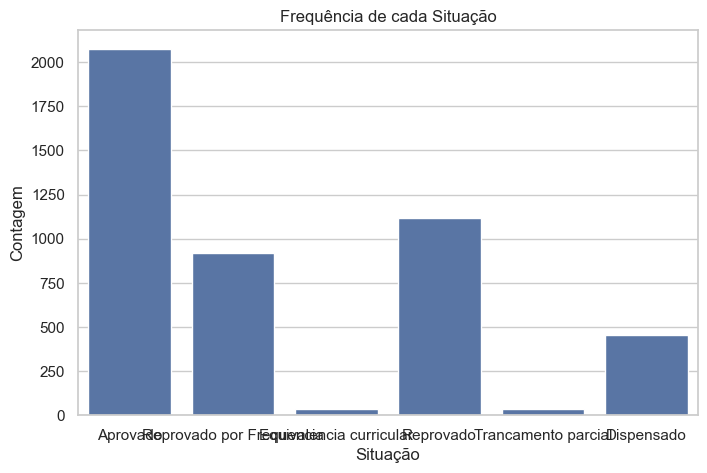

In [26]:
# ETAPA 5 – Boxplots por situação

# Boxplot de nota por situação
sns.boxplot(data=df, x="SITUACAO", y="MEDIA_FINAL")
plt.title("Distribuição da Nota por Situação")
plt.xlabel("Situação")
plt.ylabel("Média Final")
plt.show()

# Boxplot de faltas por situação
sns.boxplot(data=df, x="SITUACAO", y="NUM_FALTAS")
plt.title("Distribuição de Faltas por Situação")
plt.xlabel("Situação")
plt.ylabel("Número de faltas")
plt.show()

# Gráfico de barras – contagem por situação
sns.countplot(data=df, x="SITUACAO")
plt.title("Frequência de cada Situação")
plt.xlabel("Situação")
plt.ylabel("Contagem")
plt.show()


Matriz de correlação:
             MEDIA_FINAL  NUM_FALTAS       ANO   PERIODO
MEDIA_FINAL     1.000000   -0.413781  0.015582 -0.060256
NUM_FALTAS     -0.413781    1.000000 -0.157637 -0.027845
ANO             0.015582   -0.157637  1.000000 -0.026188
PERIODO        -0.060256   -0.027845 -0.026188  1.000000


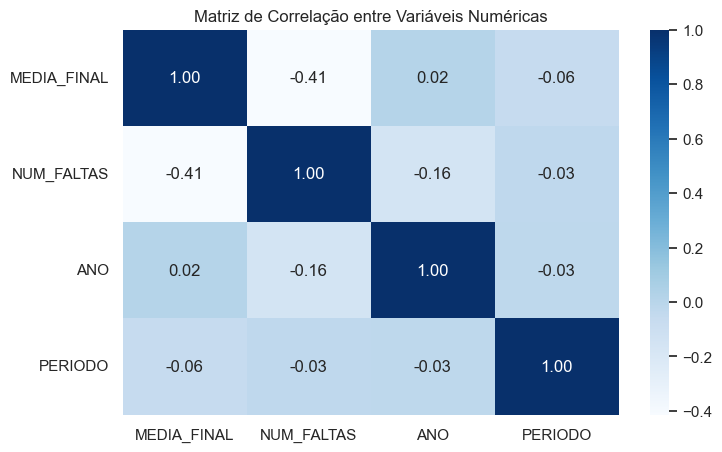

In [27]:
# ETAPA 6 – Correlações numéricas

numeric_cols = ["MEDIA_FINAL", "NUM_FALTAS", "ANO", "PERIODO"]
corr = df[numeric_cols].corr()

print("Matriz de correlação:")
print(corr)

sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues")
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.show()


In [28]:
#  Teste t para notas entre duas situações

aprov = df[df["SITUACAO"] == "Aprovado"]["MEDIA_FINAL"]
reprov = df[df["SITUACAO"] == "Reprovado"]["MEDIA_FINAL"]

# cuidado: só roda se tiver amostras suficientes nas duas
if len(aprov) > 1 and len(reprov) > 1:
    t_stat, p_val = ttest_ind(aprov, reprov, equal_var=False)
    print("Teste t – Aprovado vs Reprovado (nota)")
    print("t =", t_stat, "p =", p_val)
else:
    print("Amostra insuficiente para teste t entre aprovados e reprovados.")


Teste t – Aprovado vs Reprovado (nota)
t = 87.52599498432197 p = 0.0


In [29]:
# ANOVA: notas entre disciplinas

# Pegar apenas algumas disciplinas com bastante aluno (ex: top 5)
top_disciplinas = df["DISCIPLINA"].value_counts().head(5).index
subset = df[df["DISCIPLINA"].isin(top_disciplinas)]

grupos = [subset[subset["DISCIPLINA"] == d]["MEDIA_FINAL"] for d in top_disciplinas]

if all(len(g) > 1 for g in grupos):
    f_stat, p_val = f_oneway(*grupos)
    print("ANOVA – Notas entre disciplinas top 5")
    print("F =", f_stat, "p =", p_val)
else:
    print("Amostra insuficiente para ANOVA entre disciplinas.")


ANOVA – Notas entre disciplinas top 5
F = 88.49656471894188 p = 1.393922084099806e-72


In [30]:
# Qui-quadrado: DISCIPLINA x SITUAÇÃO

conting = pd.crosstab(df["DISCIPLINA"], df["SITUACAO"])
chi2, p, dof, expected = chi2_contingency(conting)

print("Teste Qui-quadrado – DISCIPLINA x SITUAÇÃO")
print("chi2 =", chi2, "p =", p, "graus de liberdade =", dof)

Teste Qui-quadrado – DISCIPLINA x SITUAÇÃO
chi2 = 427.29517014893963 p = 4.366672029653574e-78 graus de liberdade = 20


#### Pipeline de modelagem sem vazamento de informação

**Problema**: Na prática, para inferência teremos apenas MATR_ALUNO, ANO, PERIODO, DISCIPLINA. Não teremos MEDIA_FINAL nem NUM_FALTAS.

**Solução**: Pipeline em duas etapas:
1. **Regressões auxiliares**: Prever MEDIA_FINAL e NUM_FALTAS usando apenas ANO, PERIODO, DISCIPLINA (e características históricas do aluno, se disponíveis)
2. **Classificação final**: Usar as previsões das regressões + ANO, PERIODO, DISCIPLINA para classificar a situação



In [31]:
# ETAPA 1: Criar features históricas do aluno (usando apenas dados disponíveis na inferência)
# Essas features são calculadas com base no histórico ANTES do registro atual

def criar_features_historicas(df_base):
    """
    Cria features históricas do aluno baseadas apenas em:
    - MATR_ALUNO, ANO, PERIODO, DISCIPLINA (disponíveis na inferência)
    - Histórico anterior do aluno (calculado a partir dos dados)
    """
    df_work = df_base.copy()
    df_work = df_work.sort_values(["MATR_ALUNO", "ANO", "PERIODO", "DISCIPLINA"])
    
    # Para cada registro, calcular estatísticas do histórico ANTES desse registro
    features_hist = []
    
    for idx, row in df_work.iterrows():
        matr = row["MATR_ALUNO"]
        ano = row["ANO"]
        periodo = row["PERIODO"]
        disc = row["DISCIPLINA"]
        
        # Histórico ANTES do registro atual (mesmo aluno, registros anteriores)
        mask_antes = (
            (df_work["MATR_ALUNO"] == matr) &
            (
                (df_work["ANO"] < ano) |
                ((df_work["ANO"] == ano) & (df_work["PERIODO"] < periodo))
            )
        )
        
        hist_antes = df_work[mask_antes]
        
        # Features históricas (calculadas apenas com dados disponíveis na inferência)
        features = {
            "n_disciplinas_anteriores": len(hist_antes),
            "taxa_aprovacao_historica": (hist_antes["SITUACAO"] == "Aprovado").mean() if len(hist_antes) > 0 else 0.5,
            "n_reprovacoes_historico": (hist_antes["SITUACAO"].isin(["Reprovado", "Reprovado por Frequencia"])).sum(),
            "disciplina_ja_cursada": (hist_antes["DISCIPLINA"] == disc).any(),
            "n_vezes_disciplina": (hist_antes["DISCIPLINA"] == disc).sum(),
        }
        
        # Se tivermos MEDIA_FINAL e NUM_FALTAS no histórico (apenas para treino), podemos calcular médias
        # Mas na inferência não teremos esses valores, então não usamos diretamente
        # Em vez disso, usamos apenas as taxas e contagens baseadas em SITUACAO
        
        features_hist.append(features)
    
    df_features = pd.DataFrame(features_hist, index=df_work.index)
    return df_features

# Criar features históricas
print("Criando features históricas dos alunos...")
features_historicas = criar_features_historicas(df)
df_com_features = pd.concat([df.reset_index(drop=True), features_historicas.reset_index(drop=True)], axis=1)

print(f"Features criadas: {list(features_historicas.columns)}")
print(f"\nExemplo das primeiras linhas:")
df_com_features[["MATR_ALUNO", "ANO", "PERIODO", "DISCIPLINA"] + list(features_historicas.columns)].head(10)



Criando features históricas dos alunos...
Features criadas: ['n_disciplinas_anteriores', 'taxa_aprovacao_historica', 'n_reprovacoes_historico', 'disciplina_ja_cursada', 'n_vezes_disciplina']

Exemplo das primeiras linhas:


,MATR_ALUNO,ANO,PERIODO,DISCIPLINA,n_disciplinas_anteriores,taxa_aprovacao_historica,n_reprovacoes_historico,disciplina_ja_cursada,n_vezes_disciplina
0,1,2013,1,2,0,0.5,0,False,0
1,2,2013,1,1,0,0.5,0,False,0
2,3,2013,1,4,0,0.5,0,False,0
3,4,2013,2,2,0,0.5,0,False,0
4,4,2013,2,5,0,0.5,0,False,0
5,5,2013,2,2,0,0.5,0,False,0
6,5,2014,2,4,1,1.0,0,False,0
7,6,2013,1,4,0,0.5,0,False,0
8,7,2013,1,2,0,0.5,0,False,0
9,8,2013,2,4,0,0.5,0,False,0


##### ETAPA 2: Modelos de regressão para prever MEDIA_FINAL e NUM_FALTAS

Estes modelos usam APENAS features disponíveis na inferência:
- ANO, PERIODO, DISCIPLINA
- Features históricas do aluno (calculadas a partir do histórico anterior)



> RFR

In [32]:
# Preparar dados para regressão de MEDIA_FINAL
reg_media_df = df_com_features[df_com_features["MEDIA_FINAL_VALIDO"].notna()].copy()

# Features disponíveis na inferência
features_inferencia = ["ANO", "PERIODO"] + list(features_historicas.columns)
disc_reg = pd.get_dummies(reg_media_df["DISCIPLINA"], prefix="disc", dtype=int)

X_reg_media = pd.concat([
    reg_media_df[features_inferencia],
    disc_reg
], axis=1)

y_reg_media = reg_media_df["MEDIA_FINAL_VALIDO"]

# Divisão treino/teste
Xr_media_train, Xr_media_test, yr_media_train, yr_media_test = train_test_split(
    X_reg_media, y_reg_media, test_size=0.25, random_state=42
)

print(f"Features usadas para prever MEDIA_FINAL: {list(X_reg_media.columns)}")
print(f"Shape treino: {Xr_media_train.shape}")
print(f"Shape teste: {Xr_media_test.shape}")



Features usadas para prever MEDIA_FINAL: ['ANO', 'PERIODO', 'n_disciplinas_anteriores', 'taxa_aprovacao_historica', 'n_reprovacoes_historico', 'disciplina_ja_cursada', 'n_vezes_disciplina', 'disc_1', 'disc_2', 'disc_3', 'disc_4', 'disc_5']
Shape treino: (3087, 12)
Shape teste: (1030, 12)


In [33]:
# Modelo de regressão para MEDIA_FINAL
rf_reg_media = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=15)
rf_reg_media.fit(Xr_media_train, yr_media_train)

yr_media_pred = rf_reg_media.predict(Xr_media_test)

r2_media = r2_score(yr_media_test, yr_media_pred)
rmse_media = np.sqrt(mean_squared_error(yr_media_test, yr_media_pred))

print("=== Regressão para MEDIA_FINAL ===")
print(f"R²: {r2_media:.4f}")
print(f"RMSE: {rmse_media:.2f}")
print(f"MAE: {np.mean(np.abs(yr_media_test - yr_media_pred)):.2f}")

# Importância das variáveis
feat_imp_media = pd.Series(
    rf_reg_media.feature_importances_,
    index=X_reg_media.columns
).sort_values(ascending=False)

print("\nTop 10 variáveis mais importantes:")
print(feat_imp_media.head(10))

=== Regressão para MEDIA_FINAL ===
R²: 0.2436
RMSE: 28.30
MAE: 22.81

Top 10 variáveis mais importantes:
taxa_aprovacao_historica    0.378179
ANO                         0.168543
disc_2                      0.129958
PERIODO                     0.067847
n_reprovacoes_historico     0.053608
n_disciplinas_anteriores    0.050198
disc_3                      0.045196
n_vezes_disciplina          0.027512
disc_1                      0.026231
disc_4                      0.024459
dtype: float64


> SVM

In [34]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# SVR com kernel radial (rbf) é uma escolha comum. O parâmetro C e gamma podem ser otimizados.
svr_model = Pipeline([
    ('scaler', StandardScaler()),  # Padroniza os dados (média=0, desvio padrão=1)
    ('svr', SVR(kernel='rbf', C=10.0, gamma='scale')) # SVR
])

print(f"Features usadas para prever MEDIA_FINAL: {list(X_reg_media.columns)}")
print(f"Shape treino: {Xr_media_train.shape}")
print(f"Shape teste: {Xr_media_test.shape}")

# Treinamento do modelo SVR
# O pipeline cuida da padronização e do treino do SVR em uma única chamada.
svr_model.fit(Xr_media_train, yr_media_train)

# Previsão no conjunto de teste
yr_media_pred_svr = svr_model.predict(Xr_media_test)

# Avaliação do modelo
r2_media_svr = r2_score(yr_media_test, yr_media_pred_svr)
rmse_media_svr = np.sqrt(mean_squared_error(yr_media_test, yr_media_pred_svr))
mae_media_svr = mean_absolute_error(yr_media_test, yr_media_pred_svr)

print("\n=== Regressão para MEDIA_FINAL (SVR) ===")
print(f"R²: {r2_media_svr:.4f}")
print(f"RMSE: {rmse_media_svr:.2f}")
print(f"MAE: {mae_media_svr:.2f}")

Features usadas para prever MEDIA_FINAL: ['ANO', 'PERIODO', 'n_disciplinas_anteriores', 'taxa_aprovacao_historica', 'n_reprovacoes_historico', 'disciplina_ja_cursada', 'n_vezes_disciplina', 'disc_1', 'disc_2', 'disc_3', 'disc_4', 'disc_5']
Shape treino: (3087, 12)
Shape teste: (1030, 12)

=== Regressão para MEDIA_FINAL (SVR) ===
R²: 0.2112
RMSE: 28.90
MAE: 22.04


> RBF - NUM FALTAS

In [35]:
# Preparar dados para regressão de NUM_FALTAS
reg_faltas_df = df_com_features[df_com_features["NUM_FALTAS_VALIDO"].notna()].copy()

# Features disponíveis na inferência (mesmas de antes)
disc_reg_faltas = pd.get_dummies(reg_faltas_df["DISCIPLINA"], prefix="disc", dtype=int)

X_reg_faltas = pd.concat([
    reg_faltas_df[features_inferencia],
    disc_reg_faltas
], axis=1)

y_reg_faltas = reg_faltas_df["NUM_FALTAS_VALIDO"]

# Divisão treino/teste
Xr_faltas_train, Xr_faltas_test, yr_faltas_train, yr_faltas_test = train_test_split(
    X_reg_faltas, y_reg_faltas, test_size=0.25, random_state=42
)

print(f"Shape treino: {Xr_faltas_train.shape}")
print(f"Shape teste: {Xr_faltas_test.shape}")



Shape treino: (3086, 12)
Shape teste: (1029, 12)


In [36]:
# Modelo de regressão para NUM_FALTAS
rf_reg_faltas = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=15)
rf_reg_faltas.fit(Xr_faltas_train, yr_faltas_train)

yr_faltas_pred = rf_reg_faltas.predict(Xr_faltas_test)

r2_faltas = r2_score(yr_faltas_test, yr_faltas_pred)
rmse_faltas = np.sqrt(mean_squared_error(yr_faltas_test, yr_faltas_pred))

print("=== Regressão para NUM_FALTAS ===")
print(f"R²: {r2_faltas:.4f}")
print(f"RMSE: {rmse_faltas:.2f}")
print(f"MAE: {np.mean(np.abs(yr_faltas_test - yr_faltas_pred)):.2f}")

# Importância das variáveis
feat_imp_faltas = pd.Series(
    rf_reg_faltas.feature_importances_,
    index=X_reg_faltas.columns
).sort_values(ascending=False)

print("\nTop 10 variáveis mais importantes:")
print(feat_imp_faltas.head(10))



=== Regressão para NUM_FALTAS ===
R²: 0.1624
RMSE: 14.75
MAE: 10.60

Top 10 variáveis mais importantes:
taxa_aprovacao_historica    0.257200
ANO                         0.213353
n_disciplinas_anteriores    0.094351
n_reprovacoes_historico     0.092272
PERIODO                     0.092232
disc_2                      0.071172
n_vezes_disciplina          0.054099
disc_4                      0.040580
disc_5                      0.036784
disc_3                      0.021869
dtype: float64


> SVR NUM FALTAS

In [39]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np


svr_model_faltas = Pipeline([
    ('scaler', StandardScaler()),  # Padroniza os dados (média=0, desvio padrão=1)
    ('svr', SVR(kernel='rbf', C=10.0, gamma='scale')) # SVR
])

print(f"Shape treino: {Xr_faltas_train.shape}")
print(f"Shape teste: {Xr_faltas_test.shape}")

# Treinamento do modelo SVR
svr_model_faltas.fit(Xr_faltas_train, yr_faltas_train)

# Previsão no conjunto de teste
yr_faltas_pred_svr = svr_model_faltas.predict(Xr_faltas_test)

# Avaliação do modelo
r2_faltas_svr = r2_score(yr_faltas_test, yr_faltas_pred_svr)
rmse_faltas_svr = np.sqrt(mean_squared_error(yr_faltas_test, yr_faltas_pred_svr))
mae_faltas_svr = mean_absolute_error(yr_faltas_test, yr_faltas_pred_svr)

print("\n=== Regressão para NUM_FALTAS (SVR) ===")
print(f"R²: {r2_faltas_svr:.4f}")
print(f"RMSE: {rmse_faltas_svr:.2f}")
print(f"MAE: {mae_faltas_svr:.2f}")

Shape treino: (3086, 12)
Shape teste: (1029, 12)

=== Regressão para NUM_FALTAS (SVR) ===
R²: 0.0458
RMSE: 15.74
MAE: 9.70


##### Criaçao de um dataset final para modelos de classificação

In [38]:
# Preparar dados para classificação binária
# Filtrar apenas registros relevantes (excluir Dispensado, Equivalencia curricular, Trancamento parcial)
cls_binario_df = df_com_features[
    df_com_features["SITUACAO"].isin(["Aprovado", "Reprovado", "Reprovado por Frequencia"])
].copy()

# Criar variável target binária
cls_binario_df["TARGET"] = cls_binario_df["SITUACAO"].apply(
    lambda x: "APROVADO" if x == "Aprovado" else "REPROVADO"
)

# Gerar previsões de MEDIA_FINAL e NUM_FALTAS usando os modelos de regressão treinados
disc_cls_bin = pd.get_dummies(cls_binario_df["DISCIPLINA"], prefix="disc", dtype=int)
X_inf_cls_bin = pd.concat([
    cls_binario_df[features_inferencia],
    disc_cls_bin
], axis=1)

# Garantir que as colunas estão na mesma ordem que os modelos de regressão esperam
X_inf_cls_bin = X_inf_cls_bin.reindex(columns=X_reg_media.columns, fill_value=0)

# Prever MEDIA_FINAL e NUM_FALTAS
pred_media_bin = rf_reg_media.predict(X_inf_cls_bin)
pred_faltas_bin = rf_reg_faltas.predict(X_inf_cls_bin.reindex(columns=X_reg_faltas.columns, fill_value=0))

# Criar dataframe final com todas as features, MATR_ALUNO e target
dataset_final = pd.concat([
    cls_binario_df[["MATR_ALUNO"]].reset_index(drop=True),
    cls_binario_df[features_inferencia].reset_index(drop=True),
    pd.DataFrame({
        "MEDIA_FINAL_PRED": pred_media_bin,
        "NUM_FALTAS_PRED": pred_faltas_bin
    }, index=cls_binario_df.index).reset_index(drop=True),
    disc_cls_bin.reset_index(drop=True),
    pd.DataFrame({"TARGET": cls_binario_df["TARGET"].values}, index=cls_binario_df.index).reset_index(drop=True)
], axis=1)

print(f"Dataset final criado com {len(dataset_final)} registros")
print(f"Colunas: {list(dataset_final.columns)}")
print(f"\nDistribuição da variável target:")
print(dataset_final["TARGET"].value_counts())
print(f"\nProporção:")
print(dataset_final["TARGET"].value_counts(normalize=True))

print("\nPrimeiras linhas do dataset:")
dataset_final.head(10)

Dataset final criado com 4115 registros
Colunas: ['MATR_ALUNO', 'ANO', 'PERIODO', 'n_disciplinas_anteriores', 'taxa_aprovacao_historica', 'n_reprovacoes_historico', 'disciplina_ja_cursada', 'n_vezes_disciplina', 'MEDIA_FINAL_PRED', 'NUM_FALTAS_PRED', 'disc_1', 'disc_2', 'disc_3', 'disc_4', 'disc_5', 'TARGET']

Distribuição da variável target:
TARGET
APROVADO     2077
REPROVADO    2038
Name: count, dtype: int64

Proporção:
TARGET
APROVADO     0.504739
REPROVADO    0.495261
Name: proportion, dtype: float64

Primeiras linhas do dataset:


,MATR_ALUNO,ANO,PERIODO,n_disciplinas_anteriores,taxa_aprovacao_historica,n_reprovacoes_historico,disciplina_ja_cursada,n_vezes_disciplina,MEDIA_FINAL_PRED,NUM_FALTAS_PRED,disc_1,disc_2,disc_3,disc_4,disc_5,TARGET
0,1,2013,1,0,0.5,0,False,0,36.253373,13.990018,0,1,0,0,0,APROVADO
1,2,2013,1,0,0.5,0,False,0,73.838693,10.427194,1,0,0,0,0,REPROVADO
2,3,2013,1,0,0.5,0,False,0,36.322895,21.203706,0,0,0,1,0,REPROVADO
3,4,2013,2,0,0.5,0,False,0,34.284421,18.467629,0,1,0,0,0,APROVADO
4,4,2013,2,0,0.5,0,False,0,22.590476,20.876936,0,0,0,0,1,APROVADO
5,5,2013,2,0,0.5,0,False,0,34.284421,18.467629,0,1,0,0,0,APROVADO
6,5,2014,2,1,1.0,0,False,0,75.563243,11.123724,0,0,0,1,0,APROVADO
7,6,2013,1,0,0.5,0,False,0,36.322895,21.203706,0,0,0,1,0,REPROVADO
8,7,2013,1,0,0.5,0,False,0,36.253373,13.990018,0,1,0,0,0,REPROVADO
9,9,2013,2,0,0.5,0,False,0,57.322714,16.822355,0,0,1,0,0,REPROVADO


#### Análise de Separabilidade Linear dos Dados

Vamos visualizar os dados para verificar se as classes (APROVADO/REPROVADO) são linearmente separáveis. Isso ajuda a justificar a escolha de kernels não-lineares como RBF no SVM.



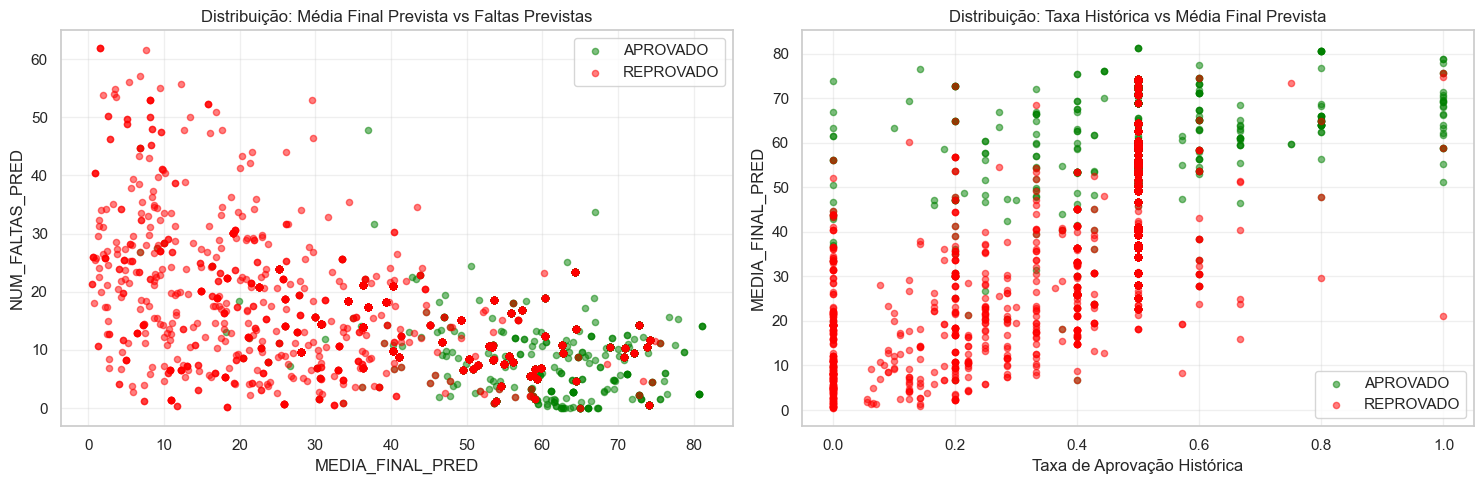

In [40]:
# Visualização 1: Scatter plots com pares de features importantes
# Vamos visualizar as duas features mais preditivas (previsões de regressão)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: MEDIA_FINAL_PRED vs NUM_FALTAS_PRED
scatter1 = axes[0].scatter(
    dataset_final[dataset_final["TARGET"] == "APROVADO"]["MEDIA_FINAL_PRED"],
    dataset_final[dataset_final["TARGET"] == "APROVADO"]["NUM_FALTAS_PRED"],
    alpha=0.5, s=20, label="APROVADO", color="green"
)
scatter2 = axes[0].scatter(
    dataset_final[dataset_final["TARGET"] == "REPROVADO"]["MEDIA_FINAL_PRED"],
    dataset_final[dataset_final["TARGET"] == "REPROVADO"]["NUM_FALTAS_PRED"],
    alpha=0.5, s=20, label="REPROVADO", color="red"
)
axes[0].set_xlabel("MEDIA_FINAL_PRED")
axes[0].set_ylabel("NUM_FALTAS_PRED")
axes[0].set_title("Distribuição: Média Final Prevista vs Faltas Previstas")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico 2: taxa_aprovacao_historica vs MEDIA_FINAL_PRED
scatter3 = axes[1].scatter(
    dataset_final[dataset_final["TARGET"] == "APROVADO"]["taxa_aprovacao_historica"],
    dataset_final[dataset_final["TARGET"] == "APROVADO"]["MEDIA_FINAL_PRED"],
    alpha=0.5, s=20, label="APROVADO", color="green"
)
scatter4 = axes[1].scatter(
    dataset_final[dataset_final["TARGET"] == "REPROVADO"]["taxa_aprovacao_historica"],
    dataset_final[dataset_final["TARGET"] == "REPROVADO"]["MEDIA_FINAL_PRED"],
    alpha=0.5, s=20, label="REPROVADO", color="red"
)
axes[1].set_xlabel("Taxa de Aprovação Histórica")
axes[1].set_ylabel("MEDIA_FINAL_PRED")
axes[1].set_title("Distribuição: Taxa Histórica vs Média Final Prevista")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



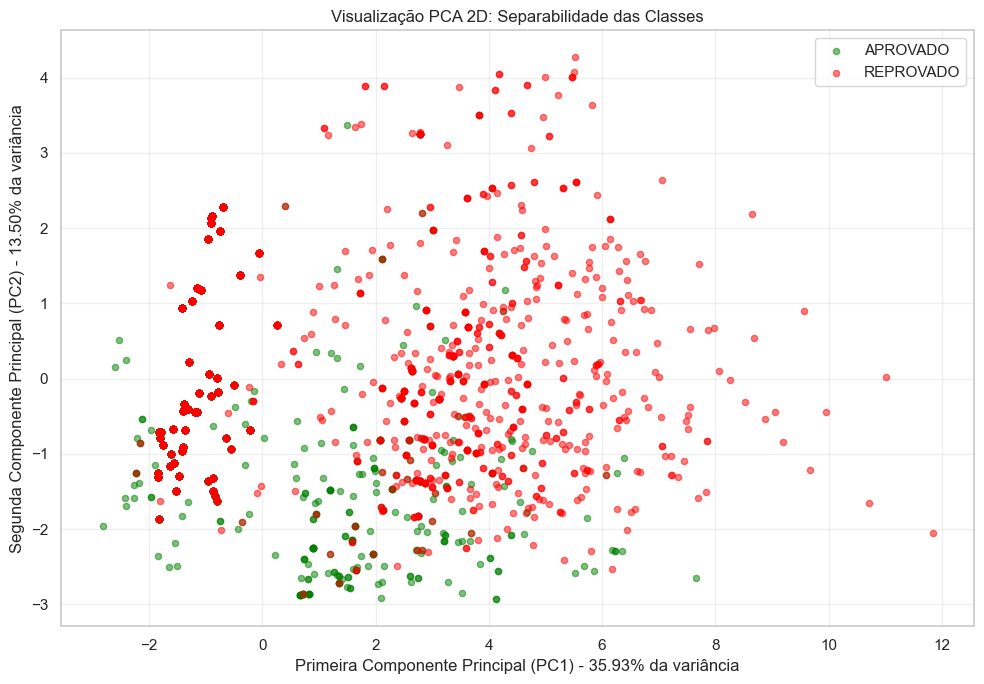

In [41]:
# Visualização 2: PCA para reduzir dimensionalidade e visualizar em 2D
from sklearn.decomposition import PCA

# Preparar features (excluir MATR_ALUNO e TARGET)
features_vis = dataset_final.drop(columns=["MATR_ALUNO", "TARGET"])
target_vis = dataset_final["TARGET"]

# Padronizar features para PCA
scaler_pca = StandardScaler()
features_scaled = scaler_pca.fit_transform(features_vis)

# Aplicar PCA para reduzir a 2 dimensões
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Criar dataframe para facilitar plotagem
df_pca = pd.DataFrame({
    "PC1": features_pca[:, 0],
    "PC2": features_pca[:, 1],
    "TARGET": target_vis.values
})

# Plotar
fig, ax = plt.subplots(figsize=(10, 7))

scatter_aprov = ax.scatter(
    df_pca[df_pca["TARGET"] == "APROVADO"]["PC1"],
    df_pca[df_pca["TARGET"] == "APROVADO"]["PC2"],
    alpha=0.5, s=20, label="APROVADO", color="green"
)

scatter_reprov = ax.scatter(
    df_pca[df_pca["TARGET"] == "REPROVADO"]["PC1"],
    df_pca[df_pca["TARGET"] == "REPROVADO"]["PC2"],
    alpha=0.5, s=20, label="REPROVADO", color="red"
)

ax.set_xlabel(f"Primeira Componente Principal (PC1) - {pca.explained_variance_ratio_[0]:.2%} da variância")
ax.set_ylabel(f"Segunda Componente Principal (PC2) - {pca.explained_variance_ratio_[1]:.2%} da variância")
ax.set_title("Visualização PCA 2D: Separabilidade das Classes")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [45]:
# Análise quantitativa: Comparar classificador linear vs não-linear
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Preparar dados
X_sep = dataset_final.drop(columns=["MATR_ALUNO", "TARGET"])
y_sep = (dataset_final["TARGET"] == "APROVADO").astype(int)  # 1 = APROVADO, 0 = REPROVADO

# Padronizar
scaler_sep = StandardScaler()
X_sep_scaled = scaler_sep.fit_transform(X_sep)

# Dividir em treino e teste
X_sep_train, X_sep_test, y_sep_train, y_sep_test = train_test_split(
    X_sep_scaled, y_sep, test_size=0.25, random_state=42, stratify=y_sep
)

# 1. Classificador LINEAR (Logistic Regression)
lr_linear = LogisticRegression(max_iter=1000, random_state=42)
lr_linear.fit(X_sep_train, y_sep_train)
acc_linear = accuracy_score(y_sep_test, lr_linear.predict(X_sep_test))

# 2. SVM com kernel LINEAR
svm_linear = SVC(kernel="linear", random_state=42)
svm_linear.fit(X_sep_train, y_sep_train)
acc_svm_linear = accuracy_score(y_sep_test, svm_linear.predict(X_sep_test))

# 3. SVM com kernel RBF (não-linear)
svm_rbf = SVC(kernel="rbf", C=50, gamma="scale", random_state=42)
svm_rbf.fit(X_sep_train, y_sep_train)
acc_svm_rbf = accuracy_score(y_sep_test, svm_rbf.predict(X_sep_test))

# 4. Random Forest (não-linear por natureza)
rf_sep = RandomForestClassifier(n_estimators=100, random_state=42)
rf_sep.fit(X_sep_train, y_sep_train)
acc_rf = accuracy_score(y_sep_test, rf_sep.predict(X_sep_test))

# Comparar resultados
comparacao = pd.DataFrame({
    "Modelo": ["Logistic Regression (Linear)", "SVM Linear", "SVM RBF (Não-linear)", "Random Forest (Não-linear)"],
    "Acurácia": [acc_linear, acc_svm_linear, acc_svm_rbf, acc_rf],
    "Tipo": ["Linear", "Linear", "Não-linear", "Não-linear"]
})

print("=== Comparação: Modelos Lineares vs Não-lineares ===\n")
comparacao



=== Comparação: Modelos Lineares vs Não-lineares ===



,Modelo,Acurácia,Tipo
0,Logistic Regression (Linear),0.749271,Linear
1,SVM Linear,0.744412,Linear
2,SVM RBF (Não-linear),0.737609,Não-linear
3,Random Forest (Não-linear),0.741497,Não-linear


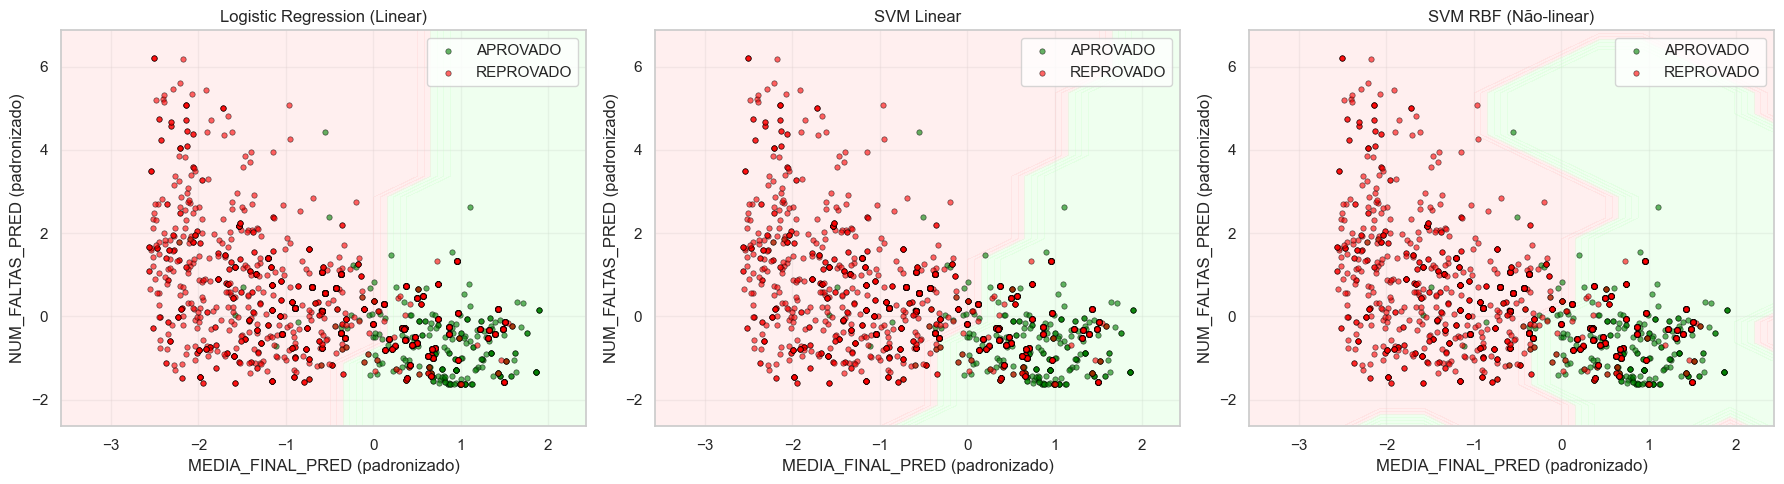

In [43]:
# Visualização 3: Fronteiras de decisão em 2D usando as features mais importantes
# Vamos usar MEDIA_FINAL_PRED e NUM_FALTAS_PRED para visualizar fronteiras

from matplotlib.colors import ListedColormap

# Preparar dados 2D
X_2d = dataset_final[["MEDIA_FINAL_PRED", "NUM_FALTAS_PRED"]].values
y_2d = (dataset_final["TARGET"] == "APROVADO").astype(int)

# Padronizar
scaler_2d = StandardScaler()
X_2d_scaled = scaler_2d.fit_transform(X_2d)

# Treinar modelos em 2D
lr_2d = LogisticRegression(max_iter=1000, random_state=42)
lr_2d.fit(X_2d_scaled, y_2d)

svm_linear_2d = SVC(kernel="linear", random_state=42)
svm_linear_2d.fit(X_2d_scaled, y_2d)

svm_rbf_2d = SVC(kernel="rbf", C=50, gamma="scale", random_state=42)
svm_rbf_2d.fit(X_2d_scaled, y_2d)

# Criar mesh para plotar fronteiras
h = 0.5  # passo do mesh
x_min, x_max = X_2d_scaled[:, 0].min() - 1, X_2d_scaled[:, 0].max() + 1
y_min, y_max = X_2d_scaled[:, 1].min() - 1, X_2d_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plotar fronteiras de decisão
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

titles = ["Logistic Regression (Linear)", "SVM Linear", "SVM RBF (Não-linear)"]
models = [lr_2d, svm_linear_2d, svm_rbf_2d]

for idx, (ax, model, title) in enumerate(zip(axes, models, titles)):
    # Prever no mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plotar contorno
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#ffcccc', '#ccffcc']))
    
    # Plotar pontos
    scatter1 = ax.scatter(
        X_2d_scaled[y_2d == 1, 0],
        X_2d_scaled[y_2d == 1, 1],
        alpha=0.6, s=15, label="APROVADO", color="green", edgecolors='black', linewidth=0.5
    )
    scatter2 = ax.scatter(
        X_2d_scaled[y_2d == 0, 0],
        X_2d_scaled[y_2d == 0, 1],
        alpha=0.6, s=15, label="REPROVADO", color="red", edgecolors='black', linewidth=0.5
    )
    
    ax.set_xlabel("MEDIA_FINAL_PRED (padronizado)")
    ax.set_ylabel("NUM_FALTAS_PRED (padronizado)")
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()